In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats
import statsmodels.api as sm
import os 
import numpy as np


In [2]:
#function to read multiple csv files in a directorty and load them into one single dataframe
def load_csv_files(directory):
    data_frames = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            try:
                df = pd.read_csv(file_path, on_bad_lines='skip')  #avoid errors while reading 
                data_frames.append(df)
            except pd.errors.ParserError as e:
                print(f"Error reading {file_path}: {e}")
    return pd.concat(data_frames, ignore_index=True)



In [3]:
submissions_cleaned_df= load_csv_files('submissions_cleaned')
comments_cleaned_df = load_csv_files('comments_cleaned/comms')

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


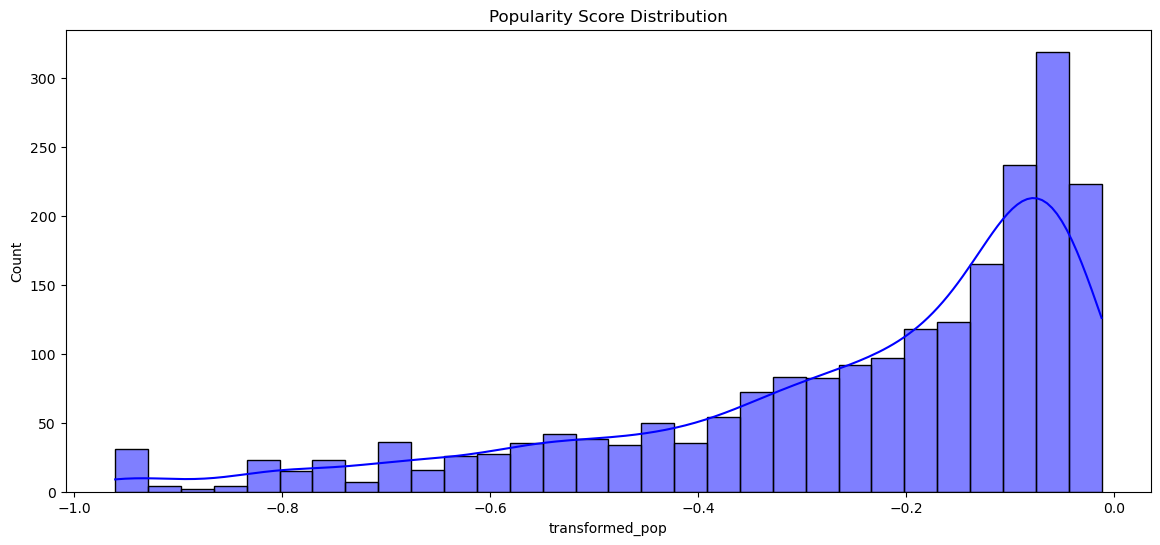

In [4]:
#histograms of popularity scores 

plt.figure(figsize=(14, 6))
submissions_cleaned_df['transformed_pop'] = np.log(submissions_cleaned_df['pop_score'])

sns.histplot(submissions_cleaned_df['transformed_pop'], bins=30, kde=True, color='blue')
plt.title('Popularity Score Distribution')
plt.show()

In [5]:

positive_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] >= 0.25]['pop_score']
neutral_submissions= (submissions_cleaned_df['sentiment_score'] > -0.25) & (submissions_cleaned_df['sentiment_score'] < 0.5)
neutral_popularity = submissions_cleaned_df.loc[neutral_submissions, 'pop_score']
negative_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] <=-0.25 ]['pop_score']

#we can assume normally distributed data based on teh number of samples here 

print("Number of positive samples:", positive_popularity.count())
print("Number of neutral samples:", neutral_popularity.count())
print("Number of negative samples:", negative_popularity.count())

print("\n\n")

print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(positive_popularity, neutral_popularity, negative_popularity).pvalue)

Number of positive samples: 831
Number of neutral samples: 1154
Number of negative samples: 734



Result of ANOVA test: 

 The p value is: 
2.7836092824140895e-20


In [6]:
df_positive = pd.DataFrame({'pop_score': positive_popularity, 'sentiment_group': 'Positive'})
df_neutral = pd.DataFrame({'pop_score': neutral_popularity, 'sentiment_group': 'Neutral'})
df_negative = pd.DataFrame({'pop_score': negative_popularity, 'sentiment_group': 'Negative'})

#join all the datafarmes along with the sentiment group
combined_df = pd.concat([df_positive, df_neutral, df_negative])


tukey = pairwise_tukeyhsd(combined_df['pop_score'], groups=combined_df['sentiment_group'])
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
Negative  Neutral  -0.1332    0.0 -0.1669 -0.0995   True
Negative Positive  -0.0513 0.0026 -0.0874 -0.0151   True
 Neutral Positive    0.082    0.0  0.0495  0.1145   True
--------------------------------------------------------


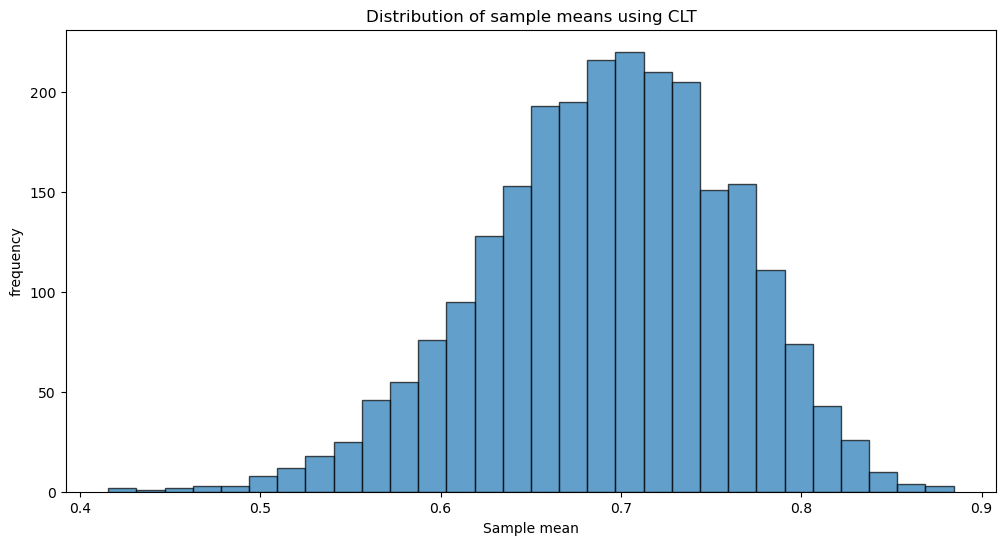

In [176]:
#apply CLT to the pop_score column to hopefully get a more normal distribution of pop_scores

sample_size = 20 
num_samples = submissions_cleaned_df.shape[0]

def applyCLT(data, sample_size, num_samples):
    sample_means = []
    for _ in range(num_samples):  #iterate through the number of samples you want to take 
        sample = data.sample(n=sample_size, replace=True) #take a sample of size smaple_size 
        sample_means.append(sample.mean())   #add the mean of that sample top the sample_means list 
    return sample_means


sample_means = applyCLT(submissions_cleaned_df['pop_score'], sample_size, num_samples)
submissions_cleaned_df['pop_score_CLT'] = sample_means

plt.figure(figsize=(12, 6))
plt.hist(sample_means, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of sample means using CLT')
plt.xlabel('Sample mean')
plt.ylabel('frequency')
plt.show()
#result: more normal looking !

In [8]:
#now redo the popularity score tests with the transformed data 

positive_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] >= 0.25]['pop_score_CLT']
neutral_submissions = (submissions_cleaned_df['sentiment_score'] > -0.25) & (submissions_cleaned_df['sentiment_score'] <0.5)
neutral_popularity = submissions_cleaned_df.loc[neutral_submissions, 'pop_score_CLT']
negative_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] <=-0.25 ]['pop_score_CLT']

print("Number of positive samples:", positive_popularity.count())
print("Number of neutral samples:", neutral_popularity.count())
print("Number of negative samples:", negative_popularity.count())

print("\n\n")

print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(positive_popularity, neutral_popularity, negative_popularity).pvalue)
#slightly better but not that much better than the popularity score based on the upvotes-downvotes(they are essentially the same)


Number of positive samples: 831
Number of neutral samples: 1154
Number of negative samples: 734



Result of ANOVA test: 

 The p value is: 
0.7552166975177642


In [14]:
# is there a reslationship between the score of comments and the sentiment of comments? 
comments_cleaned_df['score'] = pd.to_numeric(comments_cleaned_df['score'], errors='coerce')

comments_cleaned_df = comments_cleaned_df.dropna(subset=['score', 'sentiment_score'])
X = comments_cleaned_df[['score']].astype(float)
y = comments_cleaned_df['sentiment_score'].astype(float)
X = sm.add_constant(X)
X=X.dropna()
y=y.dropna()
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        sentiment_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4559
Date:                Wed, 31 Jul 2024   Prob (F-statistic):              0.500
Time:                        10:22:43   Log-Likelihood:                -1701.3
No. Observations:                2318   AIC:                             3407.
Df Residuals:                    2316   BIC:                             3418.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0115      0.011      1.088      0.2

In [105]:
#how does the sentiment score of submissions vary across differnt comment counts? 
bins = [0, 10, 100, 300,500, 750, 1000, 1500, submissions_cleaned_df['num_comments'].max()] #max for this dataframe is ~1600
labels = ['0-10', '11-100', '101-300','301-500', '501-750', '751-1000','1001-1500', '1501+']
submissions_cleaned_df['comment_bin'] = pd.cut(submissions_cleaned_df['num_comments'], bins=bins, labels=labels)


#for each bin in the labels, filter the datframe to include the rows where comment_bin = bin label

comment_bins = [submissions_cleaned_df[submissions_cleaned_df['comment_bin'] == bin]['sentiment_score'] # then get the sentiment score 
                for bin in labels]

print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(*comment_bins).pvalue)

Result of ANOVA test: 

 The p value is: 
0.026393192456808334


In [106]:
#how does the sentiment score of submissions vary across different subreddits?
subreddit_groups = [submissions_cleaned_df[submissions_cleaned_df['subreddit'] == sub]['sentiment_score']
                     for sub in submissions_cleaned_df['subreddit'].unique()]
print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(*subreddit_groups).pvalue)                        

Result of ANOVA test: 

 The p value is: 
0.002029423623111514


In [109]:
#make sure all scores are numeric to avoid type errors and drpo the non-numeric rows 
submissions_cleaned_df['sentiment_score'] = pd.to_numeric(submissions_cleaned_df['sentiment_score'], errors='coerce')


submissions_cleaned_df = submissions_cleaned_df.dropna(subset=['sentiment_score', 'time_created'])

#pd.cut sorts the sentiment scores into bins to represent negtive, positive and nuetral comments 
submissions_cleaned_df['sentiment_category'] = pd.cut(submissions_cleaned_df['sentiment_score'],
                                                      bins=[-float('inf'), -0.25, 0.25, float('inf')],
                                                      labels=['Negative', 'Neutral', 'Positive'])

#groupby hour and sentiment, then count the number of submissions under each group 
submission_counts = submissions_cleaned_df.groupby(['time_created', 'sentiment_category'], observed=True).size().unstack(fill_value=0)

positive_submissions = submission_counts['Positive']
neutral_submissions = submission_counts['Neutral']
negative_submissions = submission_counts['Negative']

print("Result of ANOVA test:\n\nThe p-value is:", anova_result.pvalue)
print(stats.f_oneway(positive_submissions, neutral_submissions, negative_submissions).pvalue)


Result of ANOVA test:

The p-value is: 0.0013157916783778187
0.0013157916783778187


In [115]:
submissions_cleaned_df['hour_of_day'] = submissions_cleaned_df['time_created'].dt.hour #get the hour each post was created 

#group by hour of the day and setniment, then count the submissions under each group 
hourly_sentiment_counts = submissions_cleaned_df.groupby(['hour_of_day', 'sentiment_category'], observed=True).size().reset_index(name='count')

print(hourly_sentiment_counts)


    hour_of_day sentiment_category  count
0             0           Negative     28
1             0            Neutral     47
2             0           Positive     32
3             1           Negative     25
4             1            Neutral     36
..          ...                ...    ...
67           22            Neutral     18
68           22           Positive     27
69           23           Negative     40
70           23            Neutral     24
71           23           Positive     37

[72 rows x 3 columns]


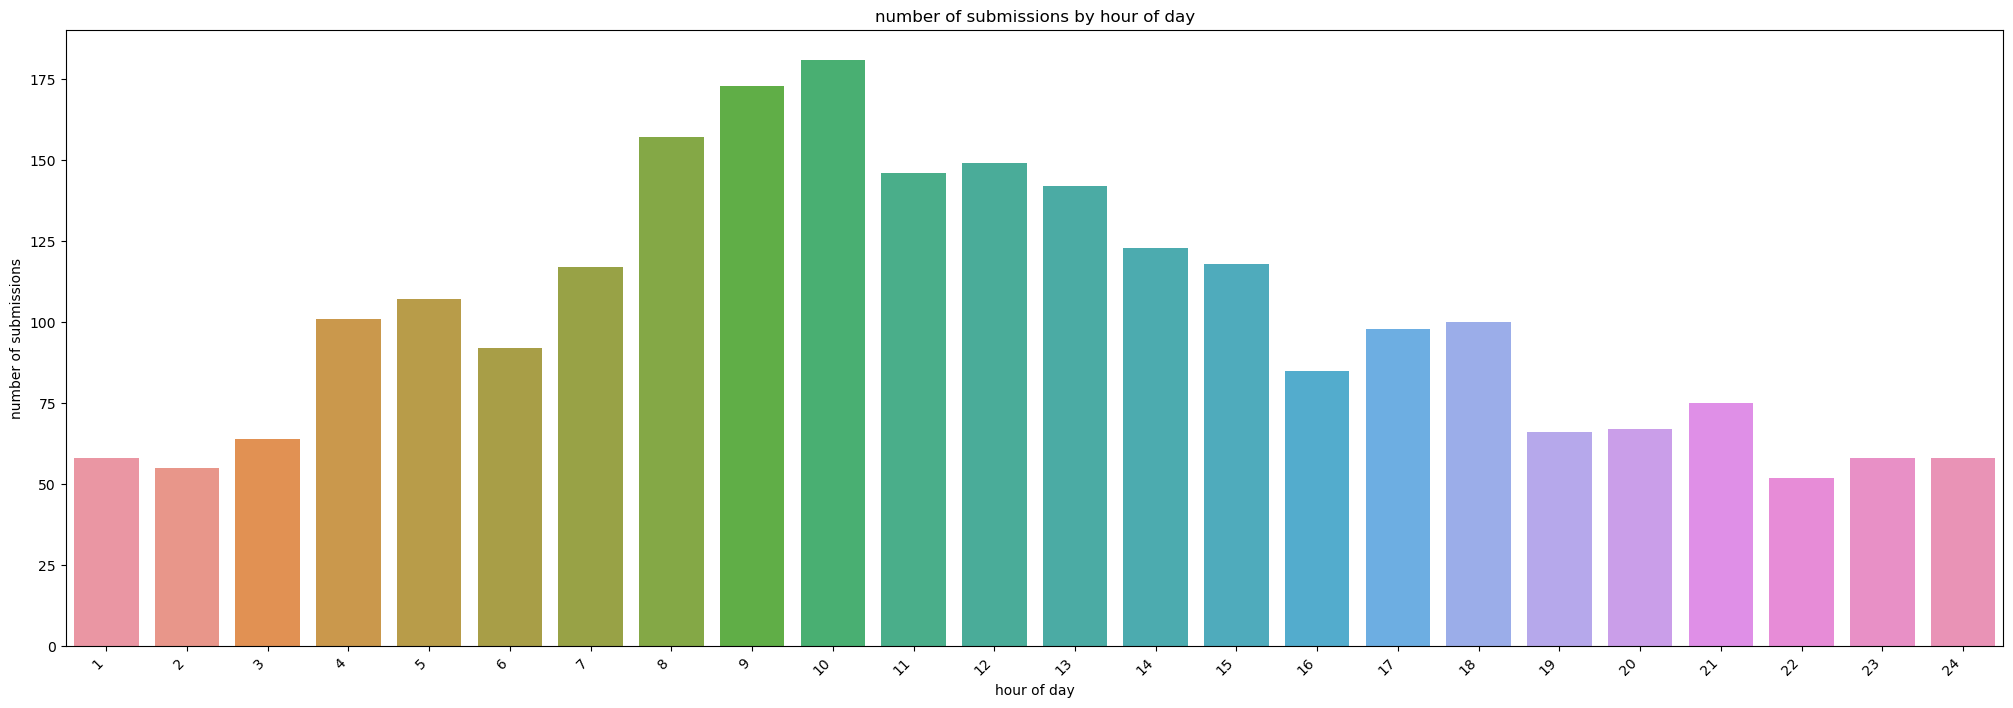

In [168]:
#visualize number of submissionsat each hour of the day 
plt.figure(figsize=(25, 8))
sns.barplot(data=hourly_counts, x='hour_of_day', y='count')
plt.title('number of submissions by hour of day')
plt.xlabel('hour of day')
plt.ylabel('number of submissions')
plt.xticks(ticks=range(24), labels=range(1, 25))
plt.xticks(rotation=45, ha='right')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


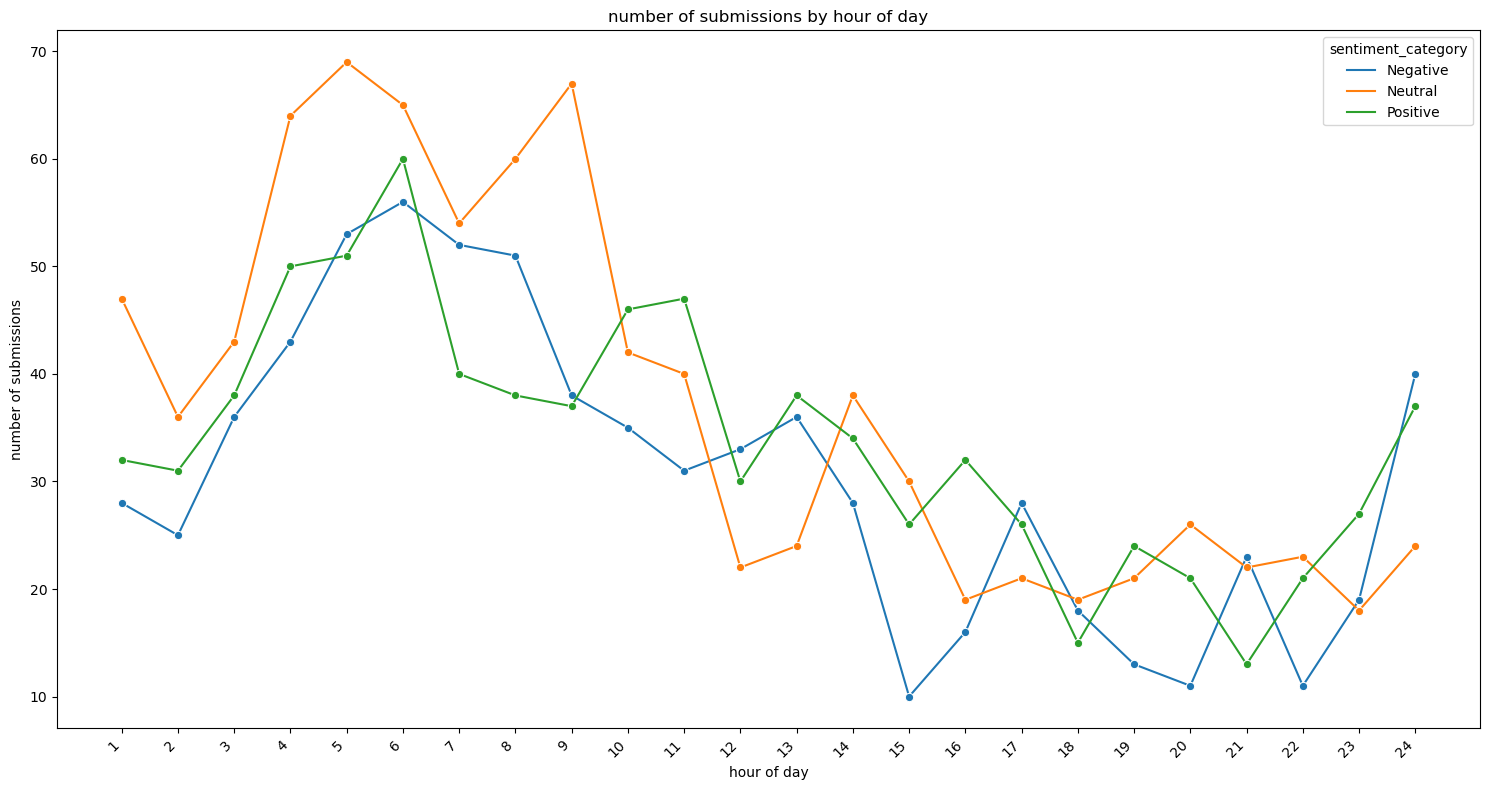

In [175]:
#using a line graph, maybe we can get rid of this? doesnt really add much and I cant figure out how to resolve the wanrings...
hourly_sentiment_counts.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
plt.figure(figsize=(15, 8))
sns.lineplot(data=hourly_sentiment_counts, x='hour_of_day', y='count', hue='sentiment_category', marker='o')
plt.title('number of submissions by hour of day')
plt.xlabel('hour of day')
plt.ylabel('number of submissions')
plt.xticks(ticks=range(24), labels=range(1, 25))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [177]:
#is the sentiment of a submission independent of the hour of day it is posted at?
contingency_table = pd.pivot_table(hourly_sentiment_counts, values='hour_of_day', index='hour_of_day', columns='sentiment_category', fill_value=0)
print("Chi-square test result:")
print(stats.chi2_contingency(contingency_table).pvalue)


Chi-square test result:
0.005056729180256783


In [178]:
#are negative posts more popular at day or night??
submissions_cleaned_df['time_of_day'] = submissions_cleaned_df['hour_of_day'].apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')

negative_comments = submissions_cleaned_df[submissions_cleaned_df['sentiment_category'] == 'Negative']

negative_grouped = negative_comments.groupby('time_of_day').size().reset_index(name='count')

negative_day = negative_comments[negative_comments['time_of_day'] == 'Day']
negative_night = negative_comments[negative_comments['time_of_day'] == 'Night']

print("t-test results on negative submissinos popularity : ")
print(ttest_ind(negative_day['pop_score'], negative_night['pop_score'], equal_var=False).pvalue)

t-test results on negative submissinos popularity : 
0.9462801656801839


In [179]:
#are postive posts more popular at day or night??
positive_comments = submissions_cleaned_df[submissions_cleaned_df['sentiment_category'] == 'Positive']

positive_grouped = positive_comments.groupby('time_of_day').size().reset_index(name='count')

positive_day = positive_comments[positive_comments['time_of_day'] == 'Day']
positive_night = positive_comments[positive_comments['time_of_day'] == 'Night']

print("t-test results on positive submissinos popularity : ")
print(ttest_ind(positive_day['pop_score'], positive_night['pop_score'], equal_var=False).pvalue)

t-test results on positive submissinos popularity : 
0.881725676652653


In [180]:
#which posts are most popular during the night? 
avg_popularity_pos = positive_night['pop_score'].mean()
avg_popularity_neg = negative_night['pop_score'].mean()

print("avg pop_score for positive submissions during the night:", avg_popularity_pos)
print("avg pop_score for negative submissions during the night:", avg_popularity_neg)

print("t-test results on positive vs negative submissinos at night popularity : ")
print(ttest_ind(positive_night['pop_score'], negative_night['pop_score'], equal_var=False).pvalue)

avg pop_score for positive submissions during the night: 0.7112811329876543
avg pop_score for negative submissions during the night: 0.7649513072067039
t-test results on positive vs negative submissinos at night popularity : 
0.009349112892447465


In [181]:
#which posts are most popular during the DAY? 
avg_popularity_pos = positive_day['pop_score'].mean()
avg_popularity_neg = negative_day['pop_score'].mean()

print("avg pop_score for positive submissions during the day:", avg_popularity_pos)
print("avg pop_score for negative submissions during the day:", avg_popularity_neg)

print("t-test results on positive vs negative submissinos at night popularity : ")
print(ttest_ind(positive_day['pop_score'], negative_day['pop_score'], equal_var=False).pvalue)

avg pop_score for positive submissions during the day: 0.7143353504889975
avg pop_score for negative submissions during the day: 0.7636895941223404
t-test results on positive vs negative submissinos at night popularity : 
0.008250884270408777


In [183]:
#get the relevant columsn for submissions_cleaned_df and put it in 'df',less typos
df = submissions_cleaned_df[['time_of_day', 'sentiment_category', 'sentiment_score']]

f_stat, p_value = f_oneway(
    df[(df['time_of_day'] == 'Day') & (df['sentiment_category'] == 'Negative')]['sentiment_score'],
    df[(df['time_of_day'] == 'Day') & (df['sentiment_category'] == 'Neutral')]['sentiment_score'],
    df[(df['time_of_day'] == 'Day') & (df['sentiment_category'] == 'Positive')]['sentiment_score'],
    df[(df['time_of_day'] == 'Night') & (df['sentiment_category'] == 'Negative')]['sentiment_score'],
    df[(df['time_of_day'] == 'Night') & (df['sentiment_category'] == 'Neutral')]['sentiment_score'],
    df[(df['time_of_day'] == 'Night') & (df['sentiment_category'] == 'Positive')]['sentiment_score']
)

print(f"ANOVA F-statistic: {f_stat}")
print(f"ANOVA p-value: {p_value}")

if p_value < 0.05:
    print("there is a singificant difference in sentiment scores during different times of day.. performing Tukey test... \n")
    
    #creates a group for each time of day and sentiment category, like Day_Positive 
    #df['group'] = df['time_of_day'] + '_' + df['sentiment_category']
    df.loc[:, 'group'] = df['time_of_day'] + '_' + df['sentiment_category']

    

    tukey = pairwise_tukeyhsd(df['sentiment_score'], groups=df['group'])
    print("\nTukey HSD results:")
    print(tukey)


ANOVA F-statistic: 3429.695065504338
ANOVA p-value: 0.0
there is a singificant difference in sentiment scores during different times of day.. performing Tukey test... 



/var/folders/kq/c_3tg9xs7db901bb7jfmfhw40000gn/T/ipykernel_14729/100563108.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'group'] = df['time_of_day'] + '_' + df['sentiment_category']



Tukey HSD results:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
  Day_Negative    Day_Neutral    0.665    0.0  0.6255  0.7044   True
  Day_Negative   Day_Positive   1.3363    0.0  1.2963  1.3764   True
  Day_Negative Night_Negative   0.0171 0.8485 -0.0243  0.0584  False
  Day_Negative  Night_Neutral   0.6658    0.0  0.6268  0.7048   True
  Day_Negative Night_Positive    1.298    0.0  1.2579  1.3382   True
   Day_Neutral   Day_Positive   0.6714    0.0  0.6328    0.71   True
   Day_Neutral Night_Negative  -0.6479    0.0 -0.6879 -0.6079   True
   Day_Neutral  Night_Neutral   0.0008    1.0 -0.0367  0.0383  False
   Day_Neutral Night_Positive   0.6331    0.0  0.5944  0.6718   True
  Day_Positive Night_Negative  -1.3193    0.0 -1.3598 -1.2787   True
  Day_Positive  Night_Neutral  -0.6705    0.0 -0.7087 -0.6324   True
  Day_Positive